In [1]:
cd "C:\Users\11197\Desktop\Study\research\20220703_ML\Dataset\Historical_data_parquet"

C:\Users\11197\Desktop\Study\research\20220703_ML\Dataset\Historical_data_parquet


In [2]:
# import necessary dependencies

import gc
import re
import os

import tensorflow as tf
import tensorflow_addons as tfa

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'
np.random.seed(42)

In [3]:
# initialize hyperparameters

INIT_LR = 1e-4
EPOCHS = 8
BATCH_SIZE = 5

In [4]:
dfCols = [
    "Credit Score",
    "First Payment Date",
    "First Time Homebuyer Flag",
    "Maturity Date",
    "Metropolitan Statistical Area (MSA) Or Metropolitan Division",
    "Mortgage Insurance Percentage (MI %)",
    "Number of Units",
    "Occupancy Status",
    "Original Combined Loan-to-Value (CLTV)",
    "Original Debt-to-Income (DTI) Ratio",
    "Original UPB",
    "Original Loan-to-Value (LTV)",
    "Original Interest Rate",
    "Channel",
    "Prepayment Penalty Mortgage (PPM) Flag",
    "Amortization Type (Formerly Product Type)",
    "Property State",
    "Property Type",
    "Postal Code",
    "Loan Sequence Number",
    "Loan Purpose",
    "Original Loan Term",
    "Number of Borrowers",
    "Seller Name",
    "Servicer Name",
    "Super Conforming Flag",
    "Pre-HARP Loan Sequence Number",
    "Program Indicator",
    "HARP Indicator",
    "Property Valuation Method",
    "Interest Only (I/O) Indicator"
]

dfTypes = {
    "Credit Score":                                                 pd.Int64Dtype(),        # Numeric, 4
    "First Payment Date":                                           pd.Int64Dtype(),        # Date, 6
    "First Time Homebuyer Flag":                                    pd.CategoricalDtype(),  # Alpha, 1
    "Maturity Date":                                                pd.Int64Dtype(),        # Date, 6
    "Metropolitan Statistical Area (MSA) Or Metropolitan Division": pd.Int64Dtype(),        # Numeric, 5
    "Mortgage Insurance Percentage (MI %)":                         pd.Int64Dtype(),        # Numeric, 3
    "Number of Units":                                              pd.CategoricalDtype(),  # Numeric, 2
    "Occupancy Status":                                             pd.CategoricalDtype(),  # Alpha, 1
    "Original Combined Loan-to-Value (CLTV)":                       pd.Int64Dtype(),        # Numeric, 3
    "Original Debt-to-Income (DTI) Ratio":                          pd.Int64Dtype(),        # Numeric, 3
    "Original UPB":                                                 pd.Int64Dtype(),        # Numeric, 12
    "Original Loan-to-Value (LTV)":                                 pd.Int64Dtype(),        # Numeric, 3
    "Original Interest Rate":                                       np.float64,             # Numeric Literal Decimal, 6
    "Channel":                                                      pd.CategoricalDtype(),  # Alpha, 1
    "Prepayment Penalty Mortgage (PPM) Flag":                       pd.CategoricalDtype(),  # Alpha, 1
    "Amortization Type (Formerly Product Type)":                    pd.CategoricalDtype(),  # Alpha, 5
    "Property State":                                               pd.CategoricalDtype(),  # Alpha, 2
    "Property Type":                                                pd.CategoricalDtype(),  # Alpha, 2
    "Postal Code":                                                  pd.Int64Dtype(),        # Numeric, 5
    "Loan Sequence Number":                                         np.str_,                # Alpha-Numeric, 12
    "Loan Purpose":                                                 pd.CategoricalDtype(),  # Alpha, 1
    "Original Loan Term":                                           pd.Int64Dtype(),        # Numeric, 3
    "Number of Borrowers":                                          pd.Int64Dtype(),        # Numeric, 2
    "Seller Name":                                                  pd.CategoricalDtype(),  # Alpha-Numeric, 60
    "Servicer Name":                                                pd.CategoricalDtype(),  # Alpha-Numeric, 60
    "Super Conforming Flag":                                        pd.CategoricalDtype(),  # Alpha, 1
    "Pre-HARP Loan Sequence Number":                                np.str_,                # Alpha-Numeric, 12
    "Program Indicator":                                            pd.CategoricalDtype(),  # Alpha-Numeric, 1
    "HARP Indicator":                                               pd.CategoricalDtype(),  # Alpha, 1
    "Property Valuation Method":                                    pd.CategoricalDtype(),  # Numeric, 1
    "Interest Only (I/O) Indicator":                                pd.CategoricalDtype()   # Alpha, 1
}

dfDateCols = [
    "First Payment Date",
    "Maturity Date"
]

dfNaNCols = [
    "Metropolitan Statistical Area (MSA) Or Metropolitan Division",
    "Super Conforming Flag",
    "Pre-HARP Loan Sequence Number",
    "HARP Indicator"
]

dfFilCols = [
    "Metropolitan Statistical Area (MSA) Or Metropolitan Division"
]

dfDelCols = [
    "Super Conforming Flag",
    "Pre-HARP Loan Sequence Number",
    "HARP Indicator"
]

dfCatCols = [
    "First Time Homebuyer Flag",
    "Number of Units",
    "Occupancy Status",
    "Channel",
    "Prepayment Penalty Mortgage (PPM) Flag",
    "Amortization Type (Formerly Product Type)",
    "Property State",
    "Property Type",
    "Loan Purpose",
    "Seller Name",
    "Servicer Name",
    "Pre-HARP Loan Sequence Number",
    "Super Conforming Flag",
    "Program Indicator",
    "HARP Indicator",
    "Property Valuation Method",
    "Interest Only (I/O) Indicator"
]

dfNinCols = {
    "Credit Score": 9999,
    "Mortgage Insurance Percentage (MI %)": 999,
    "Original Combined Loan-to-Value (CLTV)": 999,
    "Original Debt-to-Income (DTI) Ratio": 999,
    "Original Loan-to-Value (LTV)": 999,
    "Number of Borrowers": 999
}

dfKeyCols = [
    "Loan Sequence Number"
]

dfTgtCols = [
    "Credit Score"
]

dfDateCols = [
    "First Payment Date",
    "Maturity Date"
]

In [5]:
# initialize file paths

pathBase = r"C:\Users\11197\Desktop\Study\research\20220703_ML"
filePattern = re.compile(r"^sample_orig_\d\d\d\d.parquet.gzip$")

filePaths = []

for dirName, _, fileNames in os.walk(pathBase):
    for fileName in fileNames:
        if re.match(filePattern, fileName):
            filePaths.append(os.path.join(dirName, fileName))

In [6]:
# load data
df = pd.concat(map(pd.read_parquet, filePaths))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1135368 entries, 0 to 37493
Data columns (total 26 columns):
 #   Column                                                        Non-Null Count    Dtype  
---  ------                                                        --------------    -----  
 0   First Payment Date                                            1135368 non-null  int64  
 1   First Time Homebuyer Flag                                     1135368 non-null  float64
 2   Maturity Date                                                 1135368 non-null  int64  
 3   Metropolitan Statistical Area (MSA) Or Metropolitan Division  1135368 non-null  float64
 4   Mortgage Insurance Percentage (MI %)                          1135368 non-null  int64  
 5   Number of Units                                               1135368 non-null  float64
 6   Occupancy Status                                              1135368 non-null  float64
 7   Original Combined Loan-to-Value (CLTV)         

In [7]:
df

,First Payment Date,First Time Homebuyer Flag,Maturity Date,Metropolitan Statistical Area (MSA) Or Metropolitan Division,Mortgage Insurance Percentage (MI %),Number of Units,Occupancy Status,Original Combined Loan-to-Value (CLTV),Original Debt-to-Income (DTI) Ratio,Original UPB,...,Postal Code,Loan Purpose,Original Loan Term,Number of Borrowers,Seller Name,Servicer Name,Program Indicator,Property Valuation Method,Interest Only (I/O) Indicator,Credit Rank
0,200210,1.907666,202902,10420.0,25,1.899686,1.892951,85,24,122000,...,44200,1.860307,317,2,1.915687,1.917353,1.899936,1.899936,1.899936,1
1,200303,1.907666,201802,0.0,0,1.899686,1.892951,74,25,107000,...,44600,1.860307,180,2,1.915687,1.917353,1.899936,1.899936,1.899936,1
2,200303,1.907666,202903,12700.0,0,1.899686,2.018902,78,32,232000,...,2600,1.928442,313,2,1.915687,1.917353,1.899936,1.899936,1.899936,0
3,199904,1.833583,202903,17820.0,999,1.899686,1.892951,95,46,157000,...,80900,1.928442,360,1,1.915687,1.844368,1.899936,1.899936,1.899936,1
4,199905,1.907666,202904,12980.0,0,1.899686,1.892951,75,21,111000,...,49200,1.887530,360,2,1.915687,1.917353,1.899936,1.899936,1.899936,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37489,202109,2.298917,203608,0.0,0,2.287393,2.369782,80,24,58000,...,64700,2.340693,180,1,2.269388,2.289558,2.291971,2.263872,2.288206,2
37490,202111,2.298917,205110,17140.0,0,2.287393,2.279052,39,12,283000,...,45000,2.340693,360,2,2.284622,2.289558,2.291971,2.263872,2.288206,2
37491,202111,2.298917,205110,33860.0,0,2.287393,2.369782,75,43,31000,...,36100,2.311127,360,2,2.284622,2.289558,2.291971,2.263872,2.288206,2
37492,202111,2.298917,205110,45300.0,0,2.287393,2.369782,80,25,200000,...,33500,2.311127,360,2,2.284622,2.254325,2.291971,2.263872,2.288206,2


In [8]:
# preprocess data

#del df["Loan Sequence Number"]

X = df.drop("Credit Rank", axis = 1)
Y = df["Credit Rank"]
del df

# apply normalization to X the features
sc = MinMaxScaler()
X = sc.fit_transform(X)


# apply one-hot encoding to Y the labels
Y = pd.get_dummies(Y).rename(columns = {0: "Poor",          # 300 ~ 579
                                        1: "Fair",          # 580 ~ 669
                                        2: "Good",          # 670 ~ 739
                                        #3: "Very Good",     # 740 ~ 799
                                        3: "Excellent"})    # 800 ~ 850

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size = 0.2,
                                                    random_state = 42)

del X
del Y
gc.collect()

0

In [9]:
X_train = pd.DataFrame(X_train)
X_test  = pd.DataFrame(X_test)

In [10]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.393043,0.637747,0.727500,0.782067,0.000000,0.580584,0.513662,0.076229,0.020040,0.236341,...,0.666580,0.970971,0.733073,0.722864,0.000000,0.532445,0.597664,0.609950,0.308148,0.609950
1,0.395217,0.637747,0.728542,0.000000,0.000000,0.580584,0.513662,0.051153,0.050100,0.072427,...,0.591248,0.229229,0.476679,0.722864,0.010204,0.582408,0.639599,0.609950,0.308148,0.609950
2,0.090435,0.343205,0.582500,0.000000,0.030030,0.186093,0.092799,0.093280,0.044088,0.029860,...,0.327017,0.128128,0.267259,0.722864,0.010204,0.327608,0.430277,0.103897,0.052489,0.103897
3,0.783913,0.683224,0.914792,0.782067,0.000000,0.619962,0.545368,0.078235,0.033066,0.147395,...,0.617520,0.970971,0.527865,0.722864,0.010204,0.625145,0.659493,0.681860,0.345335,0.666484
4,0.131739,0.379035,0.602292,0.246482,0.025025,0.233696,0.158026,0.088265,0.053106,0.043202,...,0.364452,0.309309,0.349434,0.722864,0.000000,0.459162,0.449732,0.166602,0.084168,0.166602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908289,0.088696,0.343205,0.581667,0.384479,0.000000,0.186093,0.092799,0.078235,0.049098,0.076239,...,0.384483,0.750751,0.267259,0.722864,0.010204,0.377785,0.393471,0.103897,0.052489,0.103897
908290,0.219130,0.390562,0.644167,0.624930,0.000000,0.254796,0.160357,0.065196,0.048096,0.169632,...,0.369583,0.913914,0.127373,0.722864,0.000000,0.269579,0.236460,0.194872,0.098450,0.194872
908291,0.090435,0.343205,0.270000,0.000000,0.000000,0.186093,0.092799,0.064193,0.015030,0.109276,...,0.327017,0.956957,0.172174,0.307159,0.010204,0.279475,0.283738,0.103897,0.052489,0.103897
908292,0.568261,0.853275,0.811458,0.703257,0.000000,0.863899,0.832587,0.078235,0.019038,0.104193,...,0.799260,0.370370,0.963380,0.722864,0.010204,0.812838,0.826845,0.978778,0.494480,0.978778


In [11]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.481739,0.865591,0.457500,0.445115,0.000000,0.880090,0.850166,0.076229,0.018036,0.088945,...,0.810912,0.874875,0.879561,0.307159,0.010204,0.745708,0.792109,1.000000,0.505202,1.000000
1,0.478261,0.850495,0.437500,0.344592,0.000000,0.859517,0.826737,0.047141,0.008016,0.090216,...,0.862720,0.410410,0.977108,0.307159,0.010204,0.747719,0.782419,0.972668,0.491393,0.972668
2,0.959565,0.661041,0.998958,0.390631,0.016016,0.726024,0.674831,0.093280,0.034068,0.048285,...,0.686556,0.453453,0.837187,0.722864,0.000000,0.734938,0.727499,0.414322,0.380766,0.804086
3,0.046522,0.296346,0.561458,0.252915,0.000000,0.112697,0.004699,0.078235,0.040080,0.133418,...,0.270081,0.210210,0.004567,0.722864,0.010204,0.336926,0.365628,0.010586,0.005348,0.010586
4,0.046087,0.296346,0.248750,0.000000,0.000000,0.112697,0.004699,0.078235,0.035070,0.043202,...,0.270081,0.469469,0.000000,0.307159,0.000000,0.313022,0.364074,0.010586,0.005348,0.010586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227069,0.263913,0.433233,0.353125,0.389626,0.000000,0.311795,0.213379,0.071214,0.021042,0.078145,...,0.404303,0.454454,0.330075,0.307159,0.010204,0.348712,0.498288,0.266705,0.134740,0.266705
227070,0.565217,0.865616,0.479167,0.249698,0.000000,0.878976,0.847934,0.037111,0.009018,0.090851,...,0.884059,0.787788,0.955282,0.307159,0.010204,0.927051,0.929292,0.998452,0.504420,0.998452
227071,0.957391,0.757927,0.997917,0.845074,0.000000,0.726024,0.674831,0.063190,0.041082,0.295426,...,0.686556,0.949950,0.608309,0.722864,0.010204,0.575699,0.734238,0.811883,0.380766,0.804086
227072,0.349565,0.447342,0.706667,0.926015,0.000000,0.324560,0.644862,0.078235,0.056112,0.091487,...,0.403529,0.857858,0.184751,0.722864,0.000000,0.307121,0.430563,0.282796,0.142869,0.282796


In [12]:
Y_train

,Poor,Fair,Good,Excellent
9456,0,0,0,1
29073,0,0,1,0
31916,1,0,0,0
7094,0,0,1,0
11163,0,0,1,0
...,...,...,...,...
11395,0,0,1,0
11010,0,0,1,0
33059,0,0,1,0
23217,0,0,1,0


In [13]:
Y_test

,Poor,Fair,Good,Excellent
27948,0,0,0,1
41006,0,0,0,1
24798,0,0,1,0
12632,0,0,1,0
20821,0,0,1,0
...,...,...,...,...
22901,0,0,1,0
45894,0,0,0,1
2675,0,0,1,0
6246,0,0,1,0


In [14]:
# define ANN

early_stopping = callbacks.EarlyStopping(
    min_delta = 10e-4,
    patience = 8,
    restore_best_weights = True
)

sgd = SGD(learning_rate = INIT_LR)

model = Sequential()

model.add(Dense(units = 72,
                activation = "relu",
                input_dim = 25))
    
model.add(Dense(units = 72,
                activation = "relu"))
model.add(Dropout(0.2))
    
model.add(Dense(units = 36,
                activation = "relu"))
model.add(Dropout(0.2))
    
model.add(Dense(units = 18,
                activation = "relu"))
model.add(Dropout(0.2))
    
model.add(Dense(units = 4,
                activation = "softmax"))


model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1),
              loss = "categorical_crossentropy",
              metrics = [tf.metrics.CategoricalAccuracy(),
                         tf.metrics.CategoricalCrossentropy(),
                         tf.metrics.Recall(),
                         tf.metrics.Precision(),
                         tfa.metrics.F1Score(num_classes = 4, threshold=0.5),
                         tf.metrics.AUC()])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 72)                1872      
                                                                 
 dense_1 (Dense)             (None, 72)                5256      
                                                                 
 dropout (Dropout)           (None, 72)                0         
                                                                 
 dense_2 (Dense)             (None, 36)                2628      
                                                                 
 dropout_1 (Dropout)         (None, 36)                0         
                                                                 
 dense_3 (Dense)             (None, 18)                666       
                                                                 
 dropout_2 (Dropout)         (None, 18)                0

In [16]:
# train ANN

H = model.fit(X_train.astype(np.float64), Y_train.astype(np.float64),
                    epochs = 8,
                    batch_size = 32)

Epoch 1/8
28385/28385 [==============================] - 42s 1ms/step - loss: 0.8194 - categorical_accuracy: 0.6469 - categorical_crossentropy: 0.8194 - recall: 0.6418 - precision: 0.6484 - f1_score: 0.2211 - auc: 0.8746
Epoch 2/8
28385/28385 [==============================] - 40s 1ms/step - loss: 0.8071 - categorical_accuracy: 0.6500 - categorical_crossentropy: 0.8071 - recall: 0.6435 - precision: 0.6521 - f1_score: 0.2334 - auc: 0.8786
Epoch 3/8
28385/28385 [==============================] - 40s 1ms/step - loss: 0.8022 - categorical_accuracy: 0.6513 - categorical_crossentropy: 0.8022 - recall: 0.6438 - precision: 0.6538 - f1_score: 0.2389 - auc: 0.8802
Epoch 4/8
28385/28385 [==============================] - 41s 1ms/step - loss: 0.7992 - categorical_accuracy: 0.6521 - categorical_crossentropy: 0.7992 - recall: 0.6439 - precision: 0.6548 - f1_score: 0.2413 - auc: 0.8810
Epoch 5/8
28385/28385 [==============================] - 40s 1ms/step - loss: 0.7976 - categorical_accuracy: 0.6526 

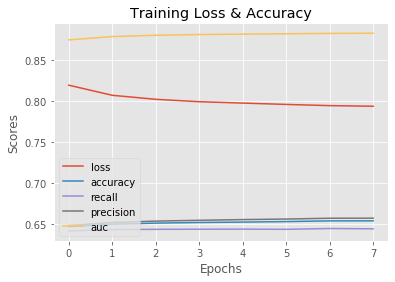

In [17]:
# plot metrics during training

plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="loss")
plt.plot(np.arange(0, EPOCHS), H.history["categorical_accuracy"], label="accuracy")
plt.plot(np.arange(0, EPOCHS), H.history["recall"], label="recall")
plt.plot(np.arange(0, EPOCHS), H.history["precision"], label="precision")
plt.plot(np.arange(0, EPOCHS), H.history["auc"], label="auc")

plt.title("Training Loss & Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Scores")
plt.legend(loc="lower left")

plt.show()

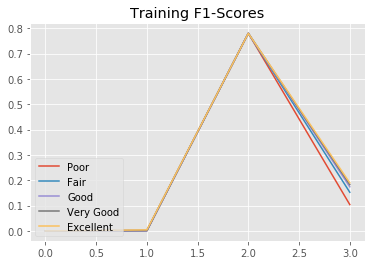

In [18]:
# plot f1-score during 
plt.style.use("ggplot")
plt.figure()

plt.plot(H.history["f1_score"][0], label="Poor")
plt.plot(H.history["f1_score"][1], label="Fair")
plt.plot(H.history["f1_score"][2], label="Good")
plt.plot(H.history["f1_score"][3], label="Very Good")
plt.plot(H.history["f1_score"][4], label="Excellent")

plt.title("Training F1-Scores")
plt.legend(loc="lower left")

plt.show()

In [19]:
Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)

Y_test = np.array(Y_test)
Y_test= np.argmax(Y_test, axis=1)

7097/7097 [==============================] - 6s 788us/step


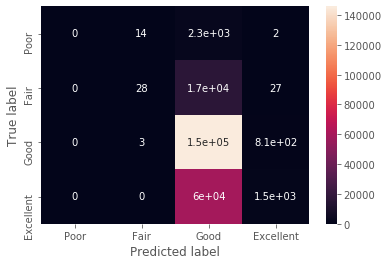

In [20]:
# evaluate with confusion matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, Y_pred)
conf_matrix = pd.DataFrame(cm, 
                           index = ["Poor", "Fair", "Good","Excellent"], 
                           columns = ["Poor", "Fair", "Good","Excellent"])

sns.heatmap(conf_matrix, annot = True)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [21]:
# evaluation from this link:
# https://lawtomated.com/accuracy-precision-recall-and-f1-scores-for-lawyers/

from sklearn.metrics import accuracy_score, average_precision_score, precision_score, f1_score, recall_score

print("------Weighted------")
print("Weighted precision", precision_score(Y_test, Y_pred, average = "weighted"))
print("Weighted recall", recall_score(Y_test, Y_pred, average = "weighted"))
print("Weighted f1-score", f1_score(Y_test, Y_pred, average = "weighted"))
print("------Macro------")
print("Macro precision", precision_score(Y_test, Y_pred, average = "macro"))
print("Macro recall", recall_score(Y_test, Y_pred, average = "macro"))
print("Macro f1-score", f1_score(Y_test, Y_pred, average = "macro"))
print("------Micro------")
print("Micro precision", precision_score(Y_test, Y_pred, average = "micro"))
print("Micro recall", recall_score(Y_test, Y_pred, average = "micro"))
print("Micro f1-score", f1_score(Y_test, Y_pred, average = "micro"))

------Weighted------
Weighted precision 0.6362231344923492
Weighted recall 0.6486299620388067
Weighted f1-score 0.5196091069504841
------Macro------


C:\Users\11197\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\11197\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro precision 0.47626676444918703
Macro recall 0.2549593779111269
Macro f1-score 0.20857384990281524
------Micro------
Micro precision 0.6486299620388067
Micro recall 0.6486299620388067
Micro f1-score 0.6486299620388067
